# SVM with sigmoid kernel

The goal of this notebook is to find the best parameters for polynomial kernel. We also want to check if the parameters depend on stock.

We will use [sklearn.svm](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) library to perform calculations. We want to pick the best parameters for **SVC**:

* C (default 1.0)
* gamma (default 1/number_of_features, so 1 in our case)
* coef0 (default 0.0)

Sigmoid kernel function: $(\tanh(\gamma \langle x,x'\rangle + coef0))$

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['10795', '12098', '11618', '1243', '11234']

dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_prepared_data(s, cv=True)
    dfs[s] = df
    dfs_cv[s] = df_cv
    dfs_test[s] = df_test

Training set length for 10795: 3030
Testing set length for 10795: 1010
Cross-validation set length for 10795: 1010
Training set length for 12098: 3030
Testing set length for 12098: 1010
Cross-validation set length for 12098: 1010
Training set length for 11618: 3030
Testing set length for 11618: 1010
Cross-validation set length for 11618: 1010
Training set length for 1243: 3030
Testing set length for 1243: 1010
Cross-validation set length for 1243: 1010
Training set length for 11234: 3030
Testing set length for 11234: 1010
Cross-validation set length for 11234: 1010


In [3]:
dfs[stocks[0]].head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
1010,2013-09-10 09:34:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1525.0, 1410.0), (1526.0, 3511.0), (1527.0, ...",1523.0,1525.0,1524.0,1410.0,1032.0,1.0,-0.154791
1011,2013-09-10 09:35:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1526.0, 3811.0), (1527.0, 3759.0), (1528.0, ...",1523.0,1526.0,1524.5,3811.0,3889.0,1.0,0.010130
1012,2013-09-10 09:36:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1526.0, 476.0), (1527.0, 3703.0), (1528.0, 6...",1525.0,1526.0,1525.5,476.0,757.0,1.0,0.227899
1013,2013-09-10 09:37:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1527.0, 419.0), (1528.0, 3608.0), (1529.0, 3...",1525.0,1527.0,1526.0,419.0,3116.0,0.0,0.762942
1014,2013-09-10 09:41:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1524.0, 1781.0), (1525.0, 11186.0), (1526.0,...",1523.0,1524.0,1523.5,1781.0,1207.0,1.0,-0.192102


In [4]:
def svm_classification(d, kernel, gamma='auto', C=1.0, degree=3, coef0=0.0):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C, degree=degree, coef0=coef0)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Methodology

We will use at first naive approach to grasp how each of the parameter influences the ROC area score and what values make sense, when the other parameters are set to defaults for parameters C and gamma.

Next we will choose parameter coef0 for SVM with gamma and C set to the best values we got.

### C parameter

The C parameter has influence over margin picked by SVM:
* for large values of **C** SVM will choose a smaller-margin hyperplane, which means that more data points will be classified correctly
* for small values of **C** SVM will choose a bigger-margin hyperplane, so there may be more misclassifications

At first we tried parameters: [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000], but after first calculations it seems that it wasn't enough, so a few more values were introduced or removed.

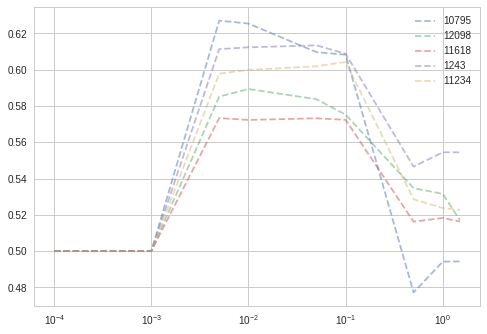

In [5]:
cs = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.5]
df_css = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_cs = pd.DataFrame(index=cs)
    df_cs['roc'] = np.zeros(len(df_cs))
    for c in cs:
        reg_svm = svm_classification(dfs[s], 'sigmoid', C=c, coef0=0)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_cs.loc[c] = logit_roc_auc
    plt.plot(df_cs, linestyle='--', label=s, marker='x', alpha=0.5)
    df_css[s] = df_cs
    
plt.legend()

##### Best values of C parameter

Choice of parameter C should be small - less than 0.1

In [6]:
for s in stocks:
    idx = df_css[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 10795 the best is 0.005
For 12098 the best is 0.01
For 11618 the best is 0.005
For 1243 the best is 0.05
For 11234 the best is 0.1


##### Influence of C parameter

The score difference between SVM with the worst choice of parameter **C** and the best choice one is shown on the output below.

In [7]:
for s in stocks:
    err_max = df_css[s]['roc'].max()
    err_min = df_css[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 10795 the diff between best and worst 0.14974913920314814
For 12098 the diff between best and worst 0.08933019515543783
For 11618 the diff between best and worst 0.07329411764705884
For 1243 the diff between best and worst 0.11339215686274517
For 11234 the diff between best and worst 0.10419731293517698


### Gamma

Gamma is a parameter which has influence over decision region - the bigger it is, the bigger influence every single row of data has. When gamma is low the decision region is very broad. When gamma is high it can even create islands of decision-boundaries around data points.

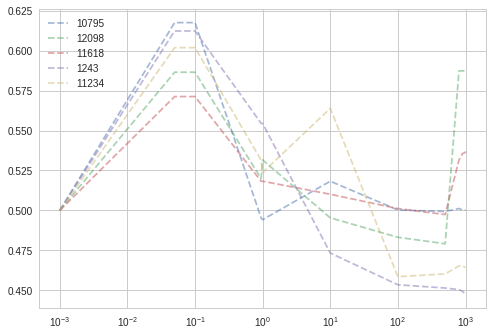

In [8]:
gammas = [0.001, 0.05, 0.1, 0.95, 1, 10, 100, 500, 800, 900, 1000, 1001]

df_gammas = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_gamma = pd.DataFrame(index=gammas)
    df_gamma['roc'] = np.zeros(len(df_gamma))
    for g in gammas:
        reg_svm = svm_classification(dfs[s], 'sigmoid', gamma=g, coef0=0)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))

        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_gamma.loc[g] = logit_roc_auc
    plt.plot(df_gamma, linestyle='--', label=s, marker='x', alpha=0.5)
    df_gammas[s] = df_gamma
    
plt.legend()

##### Best values of gamma

There is no rule, how to set this parameter.

In [9]:
for s in stocks:
    idx = df_gammas[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 10795 the best is 0.05
For 12098 the best is 800.0
For 11618 the best is 0.05
For 1243 the best is 0.05
For 11234 the best is 0.05


##### Influence of gamma

The score difference between SVM with the worst choice of **gamma** and the best choice one is shown on the output below. For scoring method we used *roc_area*. For stocks **10795**, **11618** and **4481** the difference is more than 0.1, so it's definitelly worth to experiment more.

In [10]:
for s in stocks:
    err_max = df_gammas[s]['roc'].max()
    err_min = df_gammas[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 10795 the diff between best and worst 0.12331529758976878
For 12098 the diff between best and worst 0.10814945572227119
For 11618 the diff between best and worst 0.07382352941176473
For 1243 the diff between best and worst 0.1648431372549019
For 11234 the diff between best and worst 0.14332646856918707


In [11]:
df_params = {}

for s in stocks:
    print(s)
    params = []
    for c in cs:
        for g in gammas:
            reg_svm = svm_classification(dfs[s], 'sigmoid', C=c, gamma=g)
            prediction = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
            score = roc_auc_score(dfs_cv[s]['mid_price_indicator'], prediction)
            params.append({'score': score, 'gamma': g, 'c': c})
    df_params[s] = pd.DataFrame(params)

10795
12098
11618
1243
11234


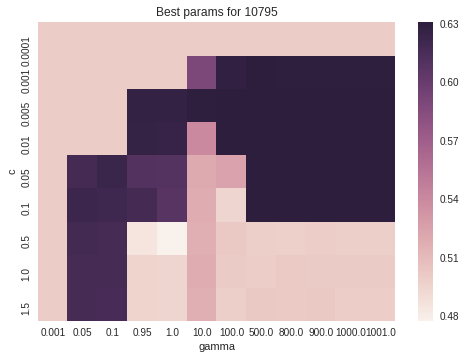

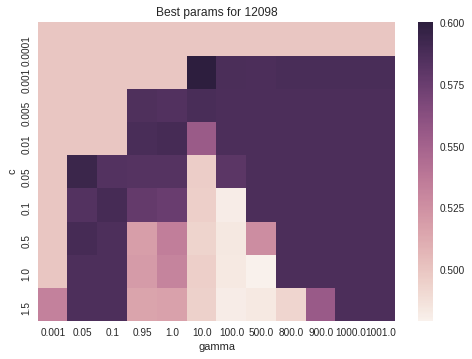

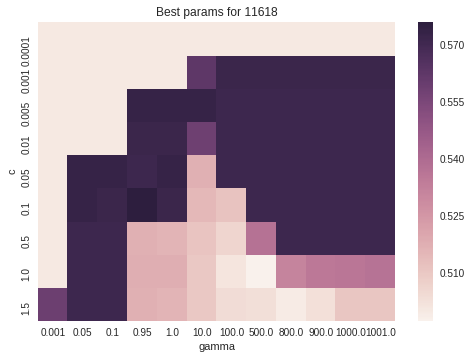

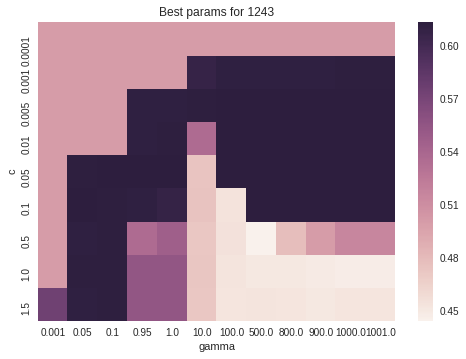

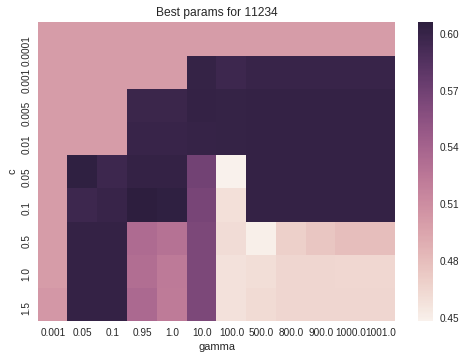

In [12]:
for s in stocks:
    df_g = df_params[s].pivot(index='c', columns='gamma', values='score')
    sns.heatmap(df_g)
    plt.title('Best params for ' + s)
    plt.figure()

In [13]:
for s in stocks:
    print(s, df_params[s].iloc[df_params[s]['score'].idxmax()])

10795 c          0.005000
gamma    100.000000
score      0.630999
Name: 30, dtype: float64
12098 c         0.001000
gamma    10.000000
score     0.600422
Name: 17, dtype: float64
11618 c        0.100000
gamma    0.950000
score    0.576098
Name: 63, dtype: float64
1243 c        0.050000
gamma    1.000000
score    0.613392
Name: 52, dtype: float64
11234 c        0.1000
gamma    0.9500
score    0.6061
Name: 63, dtype: float64


In [14]:
df_params[stocks[0]].sort_values(by='score')

,c,gamma,score
76,0.5000,1.000,0.477265
75,0.5000,0.950,0.484939
88,1.0000,1.000,0.494215
66,0.1000,100.000,0.494314
100,1.5000,1.000,0.494333
87,1.0000,0.950,0.495268
99,1.5000,0.950,0.495386
80,0.5000,800.000,0.497472
102,1.5000,100.000,0.498406
83,0.5000,1001.000,0.498524


### Coef0

For sigmoid kernel we use function:
$(\tanh(\gamma \langle x,x'\rangle + r))$, where r is specified by coef0.

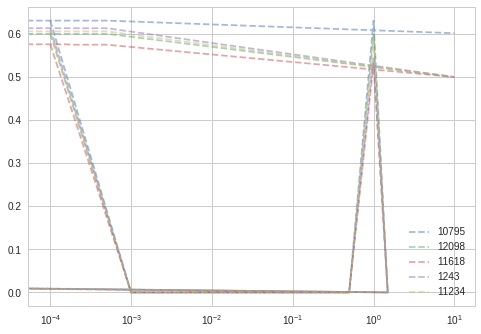

In [15]:
coeffs = [0, 0.000095, 0.0001, 0.00015, 0.0002, 0.0003, 0.0005, 1.0, 10.0]

df_coefs = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_coef = pd.DataFrame(index=cs)
    df_coef['roc'] = np.zeros(len(df_coef))
    for c in coeffs:
        best_idx = df_params[s]['score'].idxmax()
        reg_svm = svm_classification(dfs[s], 'sigmoid', C=df_params[s].iloc[best_idx]['c'], 
                                     gamma=df_params[s].iloc[best_idx]['gamma'], coef0=c)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_coef.loc[c] = logit_roc_auc
    plt.plot(df_coef, linestyle='--', label=s, marker='x', alpha=0.5)
    df_coefs[s] = df_coef

plt.legend()

##### Best values of coef0

The value of coef0 should be rather small - less than 0.5.

In [16]:
for s in stocks:
    idx = df_coefs[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 10795 the best is 0.0001
For 12098 the best is 0.0001
For 11618 the best is 0.0001
For 1243 the best is 0.0001
For 11234 the best is 0.0001


##### Influence of coef0

For all stocks choice of coef0 is significant, it can make even 0.5 difference.

In [17]:
for s in stocks:
    err_max = df_coefs[s]['roc'].max()
    err_min = df_coefs[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 10795 the diff between best and worst 0.6309985243482539
For 12098 the diff between best and worst 0.6004216926547024
For 11618 the diff between best and worst 0.5760980392156864
For 1243 the diff between best and worst 0.6133921568627452
For 11234 the diff between best and worst 0.6060998332842993


#### Best params so far

In [18]:
print(s, '\t', 'C', '\t', 'gamma', '\t', 'coef0')
    
for s in stocks:
    print(s, '\t', df_css[s]['roc'].idxmax(), '\t', df_gammas[s]['roc'].idxmax(), 
          '\t', df_coefs[s]['roc'].idxmax())

11234 	 C 	 gamma 	 coef0
10795 	 0.005 	 0.05 	 0.0001
12098 	 0.01 	 800.0 	 0.0001
11618 	 0.005 	 0.05 	 0.0001
1243 	 0.05 	 0.05 	 0.0001
11234 	 0.1 	 0.05 	 0.0001


In [19]:
df_params_coef = {}
for s in stocks:
    print(s)
    params = []
    for idx, row in df_params[s].iterrows():
        for coef in coeffs:
            reg_svm = svm_classification(dfs[s], 'sigmoid', C=row['c'], 
                                         gamma=row['gamma'], coef0=coef)
            prediction = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
            score = roc_auc_score(dfs_cv[s]['mid_price_indicator'], prediction)
            params.append({'score': score, 'gamma': row['gamma'], 'c': row['c'], 'coef0': coef})
    df_params_coef[s] = pd.DataFrame(params)
    print(df_params_coef[s]['score'].idxmax())

    

10795
268
12098
170
11618
278
1243
468
11234
567


In [20]:
df_params_coef[stocks[0]].sort_values(by='score', ascending=False)

,c,coef0,gamma,score
268,0.005,1.000000,10.00,0.632641
423,0.010,0.000000,1001.00,0.630999
622,0.100,0.000095,900.00,0.630999
630,0.100,0.000000,1000.00,0.630999
298,0.005,0.000095,900.00,0.630999
628,0.100,1.000000,900.00,0.630999
627,0.100,0.000500,900.00,0.630999
626,0.100,0.000300,900.00,0.630999
625,0.100,0.000200,900.00,0.630999
624,0.100,0.000150,900.00,0.630999


# Results

We compare reults of SVMs with the best choices of parameter against the logistic regression and SVM with defaults.

We will use naive approach - for each stock we will just pick the best values we found in the previous section.

#### Naive approach

We pick the best **C** parameter and the best **gamma** separately from the results of [section above](#Methodology), which were obtained using cross-validation set. The **coef0** parameter "depend" of the choice of the rest of parameters.

For 3 stocks the results are quite good, the rest is very bad.

In [21]:
df_results = pd.DataFrame(index=stocks)
df_results['logistic'] = np.zeros(len(stocks))
df_results['sigmoid-tunned'] = np.zeros(len(stocks))
df_results['c-tunned'] = np.zeros(len(stocks))
df_results['coef-tunned'] = np.zeros(len(stocks))
df_results['gamma-tunned'] = np.zeros(len(stocks))

0.005 10.0 1.0
0.001 100.0 10.0
0.005 100.0 10.0
0.05 1.0 0.0
0.1 0.95 0.0


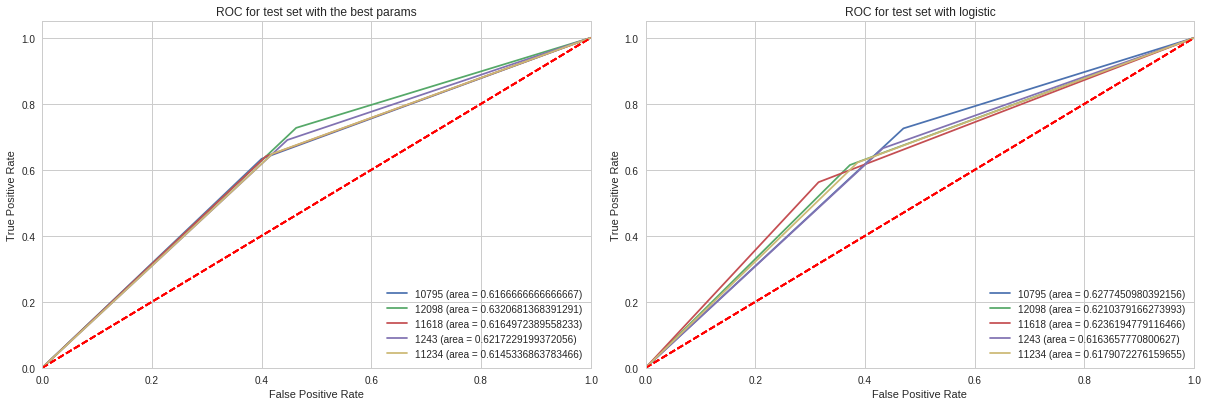

In [22]:
plt.subplot(121)

for s in stocks:
    best_idx = df_params_coef[s]['score'].idxmax()
    c = df_params_coef[s].iloc[best_idx]['c']
    gamma = df_params_coef[s].iloc[best_idx]['gamma']
    coef0 = df_params_coef[s].iloc[best_idx]['coef0']
    print(c, gamma, coef0)
    df_results['c-tunned'][s] = c
    df_results['coef-tunned'][s] = coef0
    df_results['gamma-tunned'][s] = gamma
    
    reg_svm = svm_classification(
        dfs[s], 'sigmoid', C=c, gamma=gamma, coef0=coef0)
    roc_score = lob.plot_roc(dfs_test[s], reg_svm, stock=s, title='ROC for test set with the best params')
    df_results['sigmoid-tunned'][s] = roc_score

plt.subplot(122)
for s in stocks:
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    roc_score = lob.plot_roc(dfs_test[s], reg_log, stock=s, title='ROC for test set with logistic')
    df_results['logistic'][s] = roc_score

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [23]:
df_results

,logistic,sigmoid-tunned,c-tunned,coef-tunned,gamma-tunned
10795,0.627745,0.616667,0.005,1.0,10.00
12098,0.621038,0.632068,0.001,10.0,100.00
11618,0.623619,0.616497,0.005,10.0,100.00
1243,0.616366,0.621723,0.050,0.0,1.00
11234,0.617907,0.614534,0.100,0.0,0.95


In [24]:
for s in stocks:
    ddd = df_params_coef[s]
    print(s)
    print(ddd.iloc[ddd['score'].idxmax()])
    print()

10795
c         0.005000
coef0     1.000000
gamma    10.000000
score     0.632641
Name: 268, dtype: float64

12098
c          0.001000
coef0     10.000000
gamma    100.000000
score      0.605541
Name: 170, dtype: float64

11618
c          0.005000
coef0     10.000000
gamma    100.000000
score      0.576569
Name: 278, dtype: float64

1243
c        0.050000
coef0    0.000000
gamma    1.000000
score    0.613392
Name: 468, dtype: float64

11234
c        0.1000
coef0    0.0000
gamma    0.9500
score    0.6061
Name: 567, dtype: float64



In [25]:
s = stocks[0]
reg_svm = svm_classification(dfs[s], 'sigmoid', C=0.005, 
                             gamma=10, coef0=1)
prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
score = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
score

0.6166666666666667

# Conclusions


We didn't use valid grid approach for choosing the best parameters, so there is possibility that these parameters could be improved. For one stock **2051** we have significant improvement (even when we consider other results). For stock **11618** we have small improvement.

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a>